In [ ]:
!pip install autogluon.timeseries

In [ ]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import shutil
from scipy.fftpack import fft
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set_style('white')
warnings.filterwarnings('ignore')

In [ ]:
def convert_cat_features(df):
    df=pd.get_dummies(df, columns=["holiday_name"])
    for i in list(df.columns):
      if i != "target" and i[:7]=="holiday":
        df[i]=df[i].astype(int)
    return df


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.fftpack import fft

def add_time_features(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day'] = df['date'].dt.day
    df['sin_day'] = np.sin(2 * np.pi * df['day'] / 30)
    df['cos_day'] = np.cos(2 * np.pi * df['day'] / 30)
    df['day_of_week'] = df['date'].dt.dayofweek
    df['sin_day_of_week'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['cos_day_of_week'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_year'] = df['date'].dt.dayofyear
    df['sin_day_of_year'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['cos_day_of_year'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    df['week'] = df['date'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['date'].dt.quarter
    df['season'] = (df['month'] % 12 + 3) // 3
    df['season'] = df['season'].astype(int)
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['is_friday'] = df['day_of_week'].isin([4]).astype(int)

    df['day_before_holiday'] = df['holiday'].shift().fillna(0).astype(int)
    df['day_after_holiday'] = df['holiday'].shift(-1).fillna(0).astype(int)
    df['day_before_school_holiday'] = df['school_holidays'].shift().fillna(0).astype(int)
    df['day_after_school_holiday'] = df['school_holidays'].shift(-1).fillna(0).astype(int)
    df['day_before_winter_school_holiday'] = df['winter_school_holidays'].shift().fillna(0).astype(int)
    df['day_after_winter_school_holiday'] = df['winter_school_holidays'].shift(-1).fillna(0).astype(int)
    df['holiday_and_shops_closed'] = (df['holiday'] * df['shops_closed']).astype(int)

    return df

In [ ]:
SEED = 27

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test_ids = test['id'].values
missing_cols_in_test = [
    'shutdown',
    'mini_shutdown',
    'blackout',
    'mov_change',
    'frankfurt_shutdown',
    'precipitation',
    'snow',
    'user_activity_1',
    'user_activity_2'
]
train = train.drop(missing_cols_in_test, axis=1, errors='ignore')
train['is_train'] = 1
test['is_train'] = 0
train['item_id'] = train['id'].apply(lambda x: x.split('_')[0] + '_' + x.split('_')[1])
test['item_id'] = test['id'].apply(lambda x: x.split('_')[0] + '_' + x.split('_')[1])
train = train.drop(columns=['id'])
test = test.drop(columns=['id'])
train = train.rename(columns={'orders': 'target'})
test['target'] = 0
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

train.drop(columns=['warehouse'], inplace=True)
test.drop(columns=['warehouse'], inplace=True)

train = add_time_features(train)
test = add_time_features(test)
train=convert_cat_features(train)
test=convert_cat_features(test)

train_data = TimeSeriesDataFrame.from_data_frame(train, id_column='item_id', timestamp_column='date')
test_data = TimeSeriesDataFrame.from_data_frame(test, id_column='item_id', timestamp_column='date')
train_data['is_train'] = True
test_data['is_train'] = False
combined = pd.concat([train_data, test_data])
combined = combined.convert_frequency(freq='D') # next time, choose not to run this line
combined = combined.sort_index().fill_missing_values()  # Improve upon this point
train_data = combined[combined.is_train == True]
test_data = combined[combined.is_train == False]
train_data = train_data.drop(columns=['is_train'])
test_data = test_data.drop(columns=['is_train'])
covariate_features = [col for col in train_data.columns if col not in ['target', 'item_id', 'date']]


In [ ]:
train_data.head()

target  holiday  shops_closed  winter_school_holidays  \
item_id timestamp                                                           
Brno_1  2020-12-05  6447.0      0.0           0.0                     0.0   
        2020-12-06  5338.0      0.0           0.0                     0.0   
        2020-12-07  5621.0      0.0           0.0                     0.0   
        2020-12-08  5792.0      0.0           0.0                     0.0   
        2020-12-09  5894.0      0.0           0.0                     0.0   

                    school_holidays    year  month     sin_month  cos_month  \
item_id timestamp                                                             
Brno_1  2020-12-05              0.0  2020.0   12.0 -2.449294e-16        1.0   
        2020-12-06              0.0  2020.0   12.0 -2.449294e-16        1.0   
        2020-12-07              0.0  2020.0   12.0 -2.449294e-16        1.0   
        2020-12-08              0.0  2020.0   12.0 -2.449294e-16        1.0   
        2020-12-09              0.0  2020.0   12.0 -2.449294e-16        1.0   

                    day  ...  holiday_name_Jan Hus  holiday_name_Labour Day  \
item_id timestamp        ...                                                  
Brno_1  2020-12-05  5.0  ...                   0.0                      0.0   
        2020-12-06  6.0  ...                   0.0                      0.0   
        2020-12-07  7.0  ...                   0.0                      0.0   
        2020-12-08  8.0  ...                   0.0                      0.0   
        2020-12-09  9.0  ...                   0.0                      0.0   

                    holiday_name_Memorial Day for the Martyrs of Arad  \
item_id timestamp                                                       
Brno_1  2020-12-05                                                0.0   
        2020-12-06                                                0.0   
        2020-12-07                                                0.0   
        2020-12-08                                                0.0   
        2020-12-09                                                0.0   

                    holiday_name_Memorial Day for the Victims of the Communist Dictatorships  \
item_id timestamp                                                                              
Brno_1  2020-12-05                                                0.0                          
        2020-12-06                                                0.0                          
        2020-12-07                                                0.0                          
        2020-12-08                                                0.0                          
        2020-12-09                                                0.0                          

                    holiday_name_Memorial Day for the Victims of the Holocaust  \
item_id timestamp                                                                
Brno_1  2020-12-05                                                0.0            
        2020-12-06                                                0.0            
        2020-12-07                                                0.0            
        2020-12-08                                                0.0            
        2020-12-09                                                0.0            

                    holiday_name_Memorial Day of the Republic  \
item_id timestamp                                               
Brno_1  2020-12-05                                        0.0   
        2020-12-06                                        0.0   
        2020-12-07                                        0.0   
        2020-12-08                                        0.0   
        2020-12-09                                        0.0   

                    holiday_name_National Defense Day  \
item_id timestamp                                       
Brno_1  2020-12-05                        

In [ ]:
series=list(train_data.item_ids)
series

['Brno_1',
 'Budapest_1',
 'Frankfurt_1',
 'Munich_1',
 'Prague_1',
 'Prague_2',
 'Prague_3']

In [ ]:
corresponding_models=[]
for i in series:
  single_time_series = train_data.loc[train_data.index.get_level_values('item_id') == i]
  pre_length=len(test_data.loc[test_data.index.get_level_values('item_id') == i])
  quantile_levels = [0.4, 0.45, 0.5, 0.55, 0.6]
  predictor = TimeSeriesPredictor(
      prediction_length=pre_length,
      target='target',
      eval_metric='MAPE',
      known_covariates_names=covariate_features,
      quantile_levels=quantile_levels,
      freq='D'
  )

  predictor.fit(
      single_time_series,
      presets='best_quality',
      random_seed=SEED,
      time_limit=1300
  )
  corresponding_models.append(predictor)

Beginning AutoGluon training... Time limit = 1300s
AutoGluon will save models to 'AutogluonModels/ag-20240717_164727'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          8
GPU Count:          1
Memory Avail:       48.73 GB / 50.99 GB (95.6%)
Disk Space Avail:   169.88 GB / 201.23 GB (84.4%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'freq': 'D',
 'hyperparameters': 'default',
 'known_covariates_names': ['holiday',
                            'shops_closed',
                            'winter_school_holidays',
                            'school_holidays',
                            'year',
                            'month',
                            'sin_month',
                            'cos_month',
                   

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/806M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

	-0.0831       = Validation score (-MAPE)
	14.48   s     = Training runtime
	2.87    s     = Validation (prediction) runtime
Training timeseries model TemporalFusionTransformer. Training for up to 277.5s of the 1109.9s of remaining time.
	-0.0513       = Validation score (-MAPE)
	122.08  s     = Training runtime
	0.05    s     = Validation (prediction) runtime
Training timeseries model DeepAR. Training for up to 329.2s of the 987.7s of remaining time.
	-0.0693       = Validation score (-MAPE)
	128.59  s     = Training runtime
	0.35    s     = Validation (prediction) runtime
Training timeseries model PatchTST. Training for up to 429.4s of the 858.8s of remaining time.
	-0.0606       = Validation score (-MAPE)
	76.47   s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'PatchTST': 0.31, 'TemporalFusionTransformer': 0.69}
	-0.0499       = Validation score (-MAPE)
	2.47    s     = Training runtime
	0.08    s     =

In [ ]:
predictions_list=[]
for i in range(len(corresponding_models)):
  single_time_series=train_data.loc[train_data.index.get_level_values('item_id') == series[i]]
  singe_test_data=test_data.loc[test_data.index.get_level_values('item_id') == series[i]]
  predictions = corresponding_models[i].predict(
      single_time_series,
      known_covariates=singe_test_data[covariate_features]
  )
  predictions_list.append(predictions)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [ ]:
for i in range(len(corresponding_models)):
  print(corresponding_models[i].leaderboard())

                        model  score_val  pred_time_val  fit_time_marginal  \
0            WeightedEnsemble  -0.049921       0.077015           2.466865   
1   TemporalFusionTransformer  -0.051299       0.050981         122.076366   
2                    PatchTST  -0.060619       0.026035          76.474883   
3                      DeepAR  -0.069325       0.346021         128.591431   
4               SeasonalNaive  -0.070476       1.173169           1.748690   
5                     AutoETS  -0.071100      26.970863          26.743312   
6       DynamicOptimizedTheta  -0.080323      24.184981          24.635991   
7               Chronos[base]  -0.083075       2.869222          14.482141   
8                   AutoARIMA  -0.093736      15.342048          16.280354   
9                  CrostonSBA  -0.107920      10.276395          10.265400   
10              DirectTabular  -0.139862       0.177797           8.593412   
11                       NPTS  -0.199918       0.482661         

In [ ]:
# combine all predictions
combined_predictions = pd.concat([predictions_list[0], predictions_list[1]])
combined_predictions = pd.concat([combined_predictions, predictions_list[2]])
combined_predictions = pd.concat([combined_predictions, predictions_list[3]])
combined_predictions = pd.concat([combined_predictions, predictions_list[4]])
combined_predictions = pd.concat([combined_predictions, predictions_list[5]])
combined_predictions = pd.concat([combined_predictions, predictions_list[6]])

In [ ]:
predictions=combined_predictions

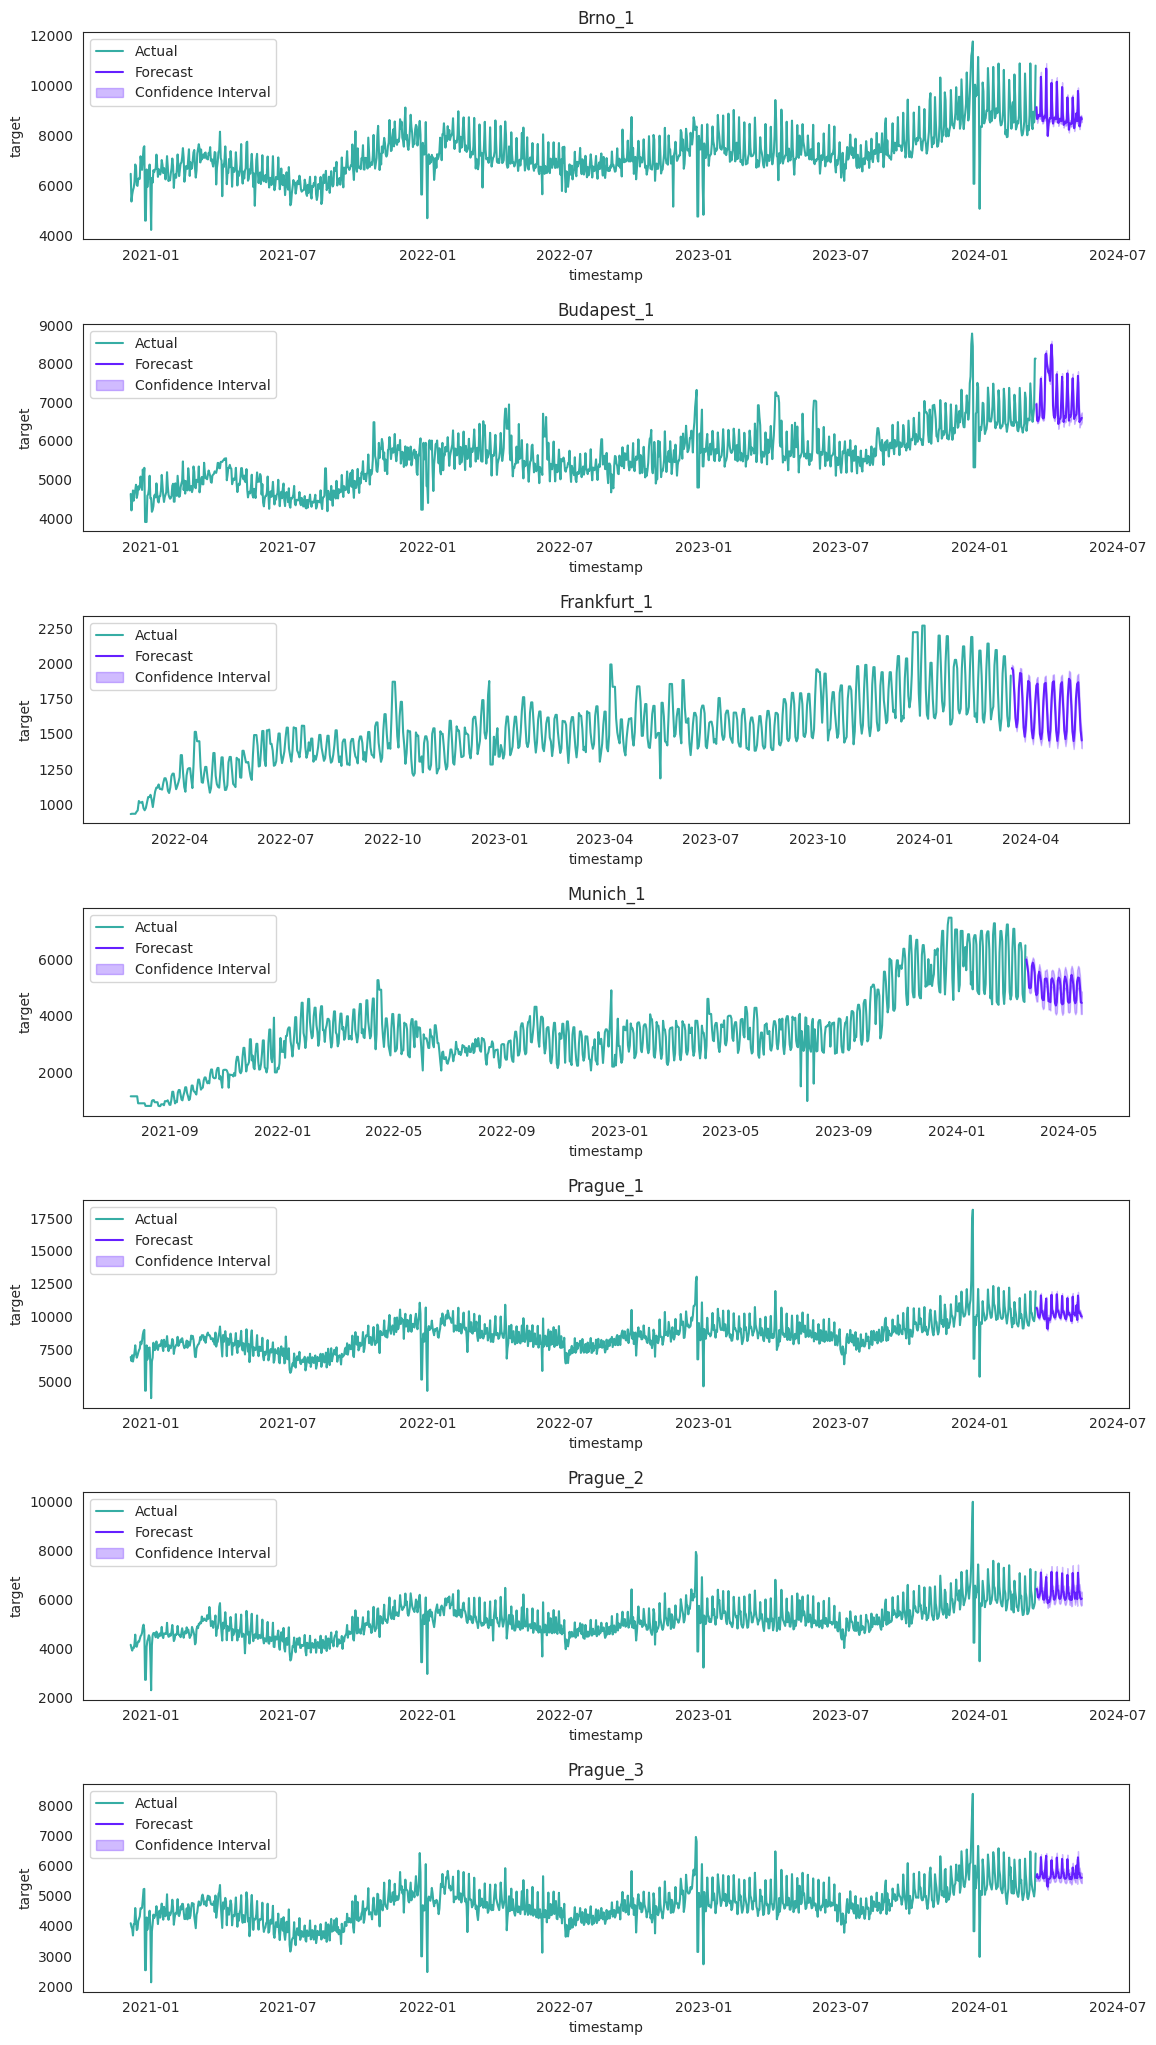

In [ ]:
unique_item_ids = predictions['item_id'].unique() if 'item_id' in predictions.columns else predictions.index.get_level_values('item_id').unique()

nrows = len(unique_item_ids)
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))
fig.tight_layout(pad=4.0)

if nrows == 1:
    axes = [axes]

for index, item_id in enumerate(unique_item_ids):
    ax = axes[index]
    actual_data = train_data.loc[(train_data.index.get_level_values('item_id') == item_id)]
    forecast_data = predictions.loc[(predictions.index.get_level_values('item_id') == item_id)]

    sns.lineplot(x=actual_data.index.get_level_values('timestamp'), y='target', data=actual_data, ax=ax, label='Actual', color=sns.color_palette('husl')[3])
    sns.lineplot(x=forecast_data.index.get_level_values('timestamp'), y='mean', data=forecast_data, ax=ax, label='Forecast', color='#651FFF')

    lower_quantile = f'{quantile_levels[0]}'
    upper_quantile = f'{quantile_levels[-1]}'
    ax.fill_between(forecast_data.index.get_level_values('timestamp'), forecast_data[lower_quantile], forecast_data[upper_quantile], color='#651FFF', alpha=0.3, label='Confidence Interval')

    ax.set_title(item_id)
    ax.legend()

plt.show()

In [ ]:
predictions = predictions.reset_index(drop=False)
predictions['timestamp'] = predictions['timestamp'].astype('str')
predictions['id'] = predictions['item_id'] + '_' + predictions['timestamp']

In [ ]:
def get_prediction(row):
    return predictions[predictions['id'] == row['id']]["mean"].values[0]

sub = pd.DataFrame({'id': test_ids, 'orders': 0})
sub['orders'] = sub.apply(get_prediction, axis=1)
sub.to_csv(f'submission_long.csv', index=False)
sub.head()

,id,orders
0,Prague_1_2024-03-16,10639.930560
1,Prague_1_2024-03-17,10586.970865
2,Prague_1_2024-03-18,10143.931575
3,Prague_1_2024-03-19,9922.859509
4,Prague_1_2024-03-20,9892.806115


In [ ]:
from google.colab import files
files.download('submission_long.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>